In [1]:
#len(tf.config.list_physical_devices("GPU")) >0

# Librerías

In [2]:
# Librerias
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.dates as mdates
from tensorflow import keras
from tensorflow.keras import layers
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Conv1D, LSTM, Dense
from statsmodels.tsa.stattools import adfuller
from keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [3]:
# Cargo el archivo CSV en un DataFrame de Pandas
df = pd.read_csv('final_dataset.csv', parse_dates=['t'], index_col=['t']).drop(columns= ['Unnamed: 0', 'pc12'])
df.columns

Index(['symbol', 'o', 'h', 'l', 'c', 'v', 'n', 'vw', 'diff', 'emaS', 'emaM',
       'emaL', 'std', 'pc', 'mvS', 'mvL', 'mnS', 'mnL', 'rsi', 'rsid', 'rlmS',
       'rlmL', 'rlmD', 'obv', 'obvmS', 'obvmL', 'obvsL', 'obvSH', 'lavgv',
       'lavm', 'lavs', 'avgv', 'ewm_12', 'ewm_26', 'macd', 'signal',
       'macd_std', 'macds', 'financial_data_age', 'P/E', 'P/S', 'P/B',
       'EPS_Growth', 'ROE', 'ROA', 'Gross_Margin', 'Operating_Margin',
       'Net_Profit_Margin', 'Current_Ratio', 'Debt_to_Equity', 'FCF',
       'spy_value', 'time_embed_day_sin', 'time_embed_day_cos',
       'time_embed_week_sin', 'time_embed_week_cos', 'time_embed_month_sin',
       'time_embed_month_cos', 'time_embed_year_sin', 'time_embed_year_cos',
       'market_correlation', 'market_long_term_trend',
       'market_short_term_trend', 'market_change', 'alpha', 'beta'],
      dtype='object')

In [4]:
unique_symbols = df['symbol'].unique()
print(unique_symbols)

['BABA' 'AAPL' 'AMZN' 'META' 'MSFT' 'TSLA' 'BAC' 'GOOG' 'JPM' 'KO' 'PFE'
 'XOM' 'CVX' 'NVDA']


In [5]:
# Como test, inicio solo creando un modelo para Amazon
data = df[df['symbol'] == 'MSFT' ].drop(columns= ['symbol', 'spy_value'])

In [6]:
# Assuming your DataFrame is called df_daily
min_time_index = data.index.min()

# Print the minimum time index
print("Minimum time index:", min_time_index)

Minimum time index: 2018-04-02 08:00:00


# Se crea dataset a nivel diario (target "close")

Tomando en cuenta una estrategia de inversión semanal y no a tan corto plazo, me hace sentido que tomemos los resultados de cierre diario. Por otra parte, dado que faltan varias horas tambien ayuda a justificar la decisión.

C:\Users\varay\AppData\Local\Temp\ipykernel_6364\2621484298.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  check = data[(data.index.get_level_values('t') >= '25-04-2022') & (data.index.get_level_values('t') <= '27-04-2022')]


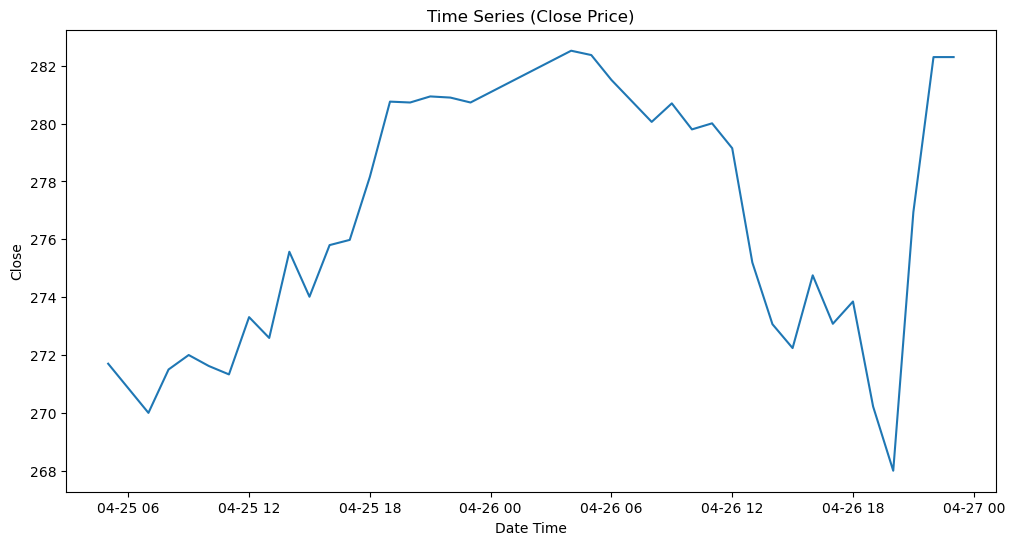

In [7]:
check = data[(data.index.get_level_values('t') >= '25-04-2022') & (data.index.get_level_values('t') <= '27-04-2022')]
#print(check['c'])

plt.figure(figsize=(12, 6))
plt.plot(check['c'])
plt.xlabel('Date Time')
plt.ylabel('Close')
plt.title('Time Series (Close Price)')
plt.show()

In [8]:
# Create a dictionary with 'mean' as the default aggregation function for all columns
agg_dict = {col: 'mean' for col in data.columns}
# Update the dictionary for 'open' and 'close' columns
agg_dict['o'] = 'last'
agg_dict['c'] = 'last'
agg_dict['h'] = 'last'
agg_dict['l'] = 'last'

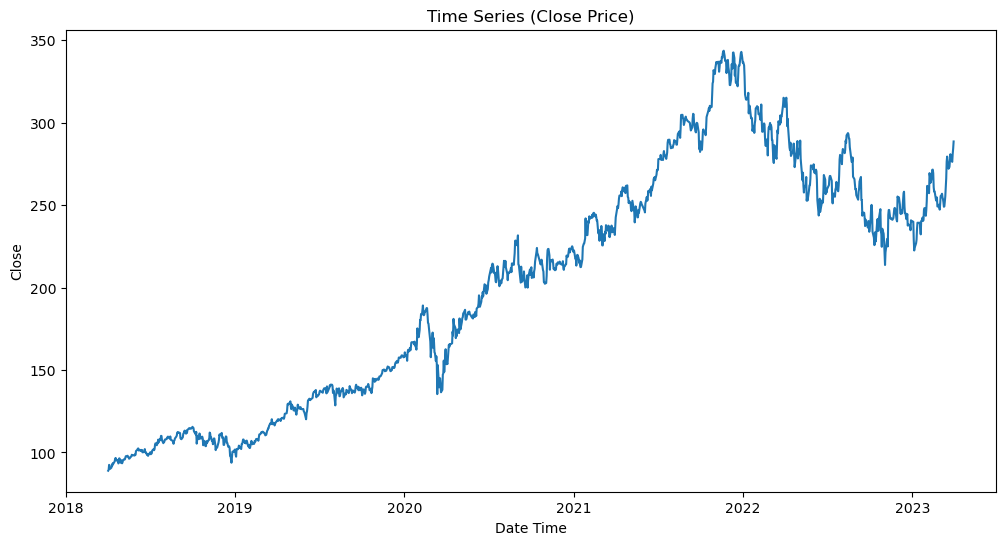

In [9]:
#df_daily = data.resample('D').mean()
# Aggregate the data
df_daily = data.resample('D').agg(agg_dict)
df_daily = df_daily.dropna(how='all')
#df_daily = df_daily.dropna() # Se eliminan días sin datos
# Visualiza la serie temporal mensual
plt.figure(figsize=(12, 6))
plt.plot(df_daily['c'])
plt.xlabel('Date Time')
plt.ylabel('Close')
plt.title('Time Series (Close Price)')
plt.show()


CREACION DE TARGET VARIACION %

In [10]:
# Assuming you have a DataFrame named df_daily with a column called 'close'
# Calculate the previous row's close value. Podria como un target dif% respecto 5 dias atras yotro target como cantidad de variaciones (pasando de + a - es 1)
df_daily['prev_close1'] = df_daily['c'].shift(1)
df_daily['prev_close5'] = df_daily['c'].shift(5)

# Calculate the difference between the current and previous close values
df_daily['close_diff1'] = (df_daily['c'] - df_daily['prev_close1']) /  df_daily['prev_close1'] *100
df_daily['close_diff5'] = (df_daily['c'] - df_daily['prev_close5']) /  df_daily['prev_close5'] *100
df_daily['close_diff_15'] = ( df_daily['close_diff1'] + df_daily['close_diff5']) 

# Drop the 'prev_close' column as it's not needed anymore
df_daily.drop(columns=['prev_close1'], inplace=True)
df_daily.drop(columns=['prev_close5'], inplace=True)
df_daily.drop(columns=['close_diff1'], inplace=True)
df_daily.drop(columns=['close_diff5'], inplace=True)



In [11]:
# Display the updated DataFrame
#df_daily[['c', 'close_diff1', 'close_diff5', 'close_diff_15']][0:10]
df_daily[['c', 'close_diff_15']][0:10]

,c,close_diff_15
t,,
2018-04-02,88.95,NaN
2018-04-03,89.44,NaN
2018-04-04,92.50,NaN
2018-04-05,90.80,NaN
2018-04-06,90.05,NaN
2018-04-09,90.80,2.912691
2018-04-10,92.70,5.737413
2018-04-11,92.05,-1.187673
2018-04-12,93.48,4.505045


In [12]:
# Assuming your DataFrame is called df_daily
min_time_index = data.index.min()

# Print the minimum time index
print("Minimum time index:", min_time_index)

Minimum time index: 2018-04-02 08:00:00


In [13]:
blank_rows = df_daily[df_daily.isnull().any(axis=1)]
blank_rows


,o,h,l,c,v,n,vw,diff,emaS,emaM,...,time_embed_month_cos,time_embed_year_sin,time_embed_year_cos,market_correlation,market_long_term_trend,market_short_term_trend,market_change,alpha,beta,close_diff_15
t,,,,,,,,,,,,,,,,,,,,,
2018-04-02,88.65,88.95,88.65,88.95,3.239910e+06,23002.266667,89.352464,0.998331,0.998610,0.999613,...,0.997423,0.999858,0.016544,0.684740,0.998461,0.998430,-0.026638,NaN,NaN,NaN
2018-04-03,89.54,89.59,89.41,89.44,2.304880e+06,15712.250000,89.227585,1.000464,1.000284,0.999744,...,0.964007,0.999994,-0.000359,0.945665,0.999466,1.000270,0.365374,NaN,NaN,NaN
2018-04-04,92.46,92.55,92.33,92.50,2.218618e+06,14729.375000,90.003050,1.002070,1.001288,1.000061,...,0.888298,0.999840,-0.017572,0.952216,0.999934,1.000612,0.283329,NaN,NaN,NaN
2018-04-05,91.56,91.56,90.63,90.80,1.851384e+06,12373.437500,92.374936,0.999031,1.000609,1.000544,...,0.773766,0.999390,-0.034780,0.982104,1.000485,1.000599,-0.303835,NaN,NaN,NaN
2018-04-06,90.05,90.05,90.05,90.05,2.304907e+06,14730.625000,91.043825,0.999332,0.999035,1.000045,...,0.625417,0.998643,-0.051978,0.978812,0.999979,0.999139,-0.174239,NaN,NaN,NaN


Eliminar filas en blancos (son pocas)

In [14]:
df_daily = df_daily.dropna() # Se eliminan días sin datos

In [15]:
null_columns = df_daily.columns[df_daily.isnull().any()]
print("Columns with missing values: ", null_columns)

null_counts = df_daily.isnull().sum()
print("\nAmount of missing values in each column:\n", null_counts)

Columns with missing values:  Index([], dtype='object')

Amount of missing values in each column:
 o                          0
h                          0
l                          0
c                          0
v                          0
                          ..
market_short_term_trend    0
market_change              0
alpha                      0
beta                       0
close_diff_15              0
Length: 65, dtype: int64


CONVERTIR VARIABLES NECESARIAS A ESTACIONARIAS

In [16]:
def adf_test(timeseries):
    result = adfuller(timeseries)
    return result[1]  # Return the p-value

def test_columns(data, threshold=0.05):
    non_stationary_columns = {}
    non_stationary_columns_justcolumns = []
    for column in data.columns:
        p_value = adf_test(data[column])
        if p_value > threshold:
            non_stationary_columns[column] = p_value
            non_stationary_columns_justcolumns.append(column)

    return non_stationary_columns, non_stationary_columns_justcolumns



In [17]:
non_stationary_columns = test_columns(df_daily)

In [18]:
# Get non-stationary columns with p-values higher than 0.05
#non_stationary_columns = test_columns(df_daily)

# Print non-stationary columns and their p-values
print("Non-stationary columns with p-value > 0.05:")
for column, p_value in non_stationary_columns[0].items():
    print(f"{column}: {p_value}")

Non-stationary columns with p-value > 0.05:
o: 0.7213204149682388
h: 0.7200294428939644
l: 0.7210079793420108
c: 0.7206885395113715
vw: 0.7167965802057471
mnS: 0.11849818785151334
mnL: 0.27213668282086034
rlmS: 0.07822259411925342
rlmL: 0.20411259683600075
obv: 0.9622809147095817
obvmS: 0.9658736157507037
obvmL: 0.9526520455047758
lavgv: 0.7463504220042523
lavm: 0.7112787354819785
ewm_12: 0.7122641777064055
ewm_26: 0.7052210405285227
macd_std: 0.1321328236092223
P/E: 0.10285988809909813
P/S: 0.7764950765254496
P/B: 0.7167965802057471
ROE: 0.12071056344770248
ROA: 0.31189747525800493
Operating_Margin: 0.19987427795264417
Net_Profit_Margin: 0.10390925360598463
Current_Ratio: 0.4690903636757203
Debt_to_Equity: 0.49382208156028085
FCF: 0.09527846362822634


In [19]:
df_daily = df_daily.copy()


In [20]:
for column in non_stationary_columns[1]:
    df_daily[f'{column}_diff'] = df_daily[column].diff()

In [21]:
for column in non_stationary_columns[1]:
    df_daily.drop(column, axis=1, inplace=True)


In [22]:
df_daily.columns

Index(['v', 'n', 'diff', 'emaS', 'emaM', 'emaL', 'std', 'pc', 'mvS', 'mvL',
       'rsi', 'rsid', 'rlmD', 'obvsL', 'obvSH', 'lavs', 'avgv', 'macd',
       'signal', 'macds', 'financial_data_age', 'EPS_Growth', 'Gross_Margin',
       'time_embed_day_sin', 'time_embed_day_cos', 'time_embed_week_sin',
       'time_embed_week_cos', 'time_embed_month_sin', 'time_embed_month_cos',
       'time_embed_year_sin', 'time_embed_year_cos', 'market_correlation',
       'market_long_term_trend', 'market_short_term_trend', 'market_change',
       'alpha', 'beta', 'close_diff_15', 'o_diff', 'h_diff', 'l_diff',
       'c_diff', 'vw_diff', 'mnS_diff', 'mnL_diff', 'rlmS_diff', 'rlmL_diff',
       'obv_diff', 'obvmS_diff', 'obvmL_diff', 'lavgv_diff', 'lavm_diff',
       'ewm_12_diff', 'ewm_26_diff', 'macd_std_diff', 'P/E_diff', 'P/S_diff',
       'P/B_diff', 'ROE_diff', 'ROA_diff', 'Operating_Margin_diff',
       'Net_Profit_Margin_diff', 'Current_Ratio_diff', 'Debt_to_Equity_diff',
       'FCF_diff'],
   

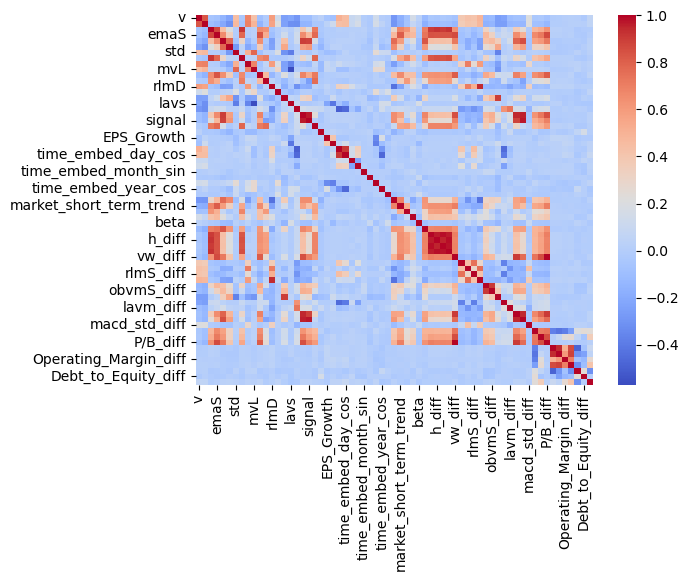

In [23]:
#Matriz correlacion
corr_matrix = df_daily.corr()
# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm')

# Show the plot
plt.show()

In [24]:
#Revisión de estacionaridad de close_dif
# test = adfuller(df_daily['close_dif'])
# test[1]

In [25]:
# Remove the 'close' column
df_daily_final = df_daily.dropna() # .drop('c', axis=1)

In [26]:
null_columns = df_daily_final.columns[df_daily.isnull().any()]
print("Columns with missing values: ", null_columns)

null_counts = df_daily_final.isnull().sum()
print("\nAmount of missing values in each column:\n", null_counts)

Columns with missing values:  Index(['o_diff', 'h_diff', 'l_diff', 'c_diff', 'vw_diff', 'mnS_diff',
       'mnL_diff', 'rlmS_diff', 'rlmL_diff', 'obv_diff', 'obvmS_diff',
       'obvmL_diff', 'lavgv_diff', 'lavm_diff', 'ewm_12_diff', 'ewm_26_diff',
       'macd_std_diff', 'P/E_diff', 'P/S_diff', 'P/B_diff', 'ROE_diff',
       'ROA_diff', 'Operating_Margin_diff', 'Net_Profit_Margin_diff',
       'Current_Ratio_diff', 'Debt_to_Equity_diff', 'FCF_diff'],
      dtype='object')

Amount of missing values in each column:
 v                         0
n                         0
diff                      0
emaS                      0
emaM                      0
                         ..
Operating_Margin_diff     0
Net_Profit_Margin_diff    0
Current_Ratio_diff        0
Debt_to_Equity_diff       0
FCF_diff                  0
Length: 65, dtype: int64


Seasonality

In [27]:
# def find_best_seasonal_frequency(timeseries, min_freq, max_freq):
#     best_freq = None
#     lowest_residual_variance = np.inf

#     for freq in range(min_freq, max_freq + 1):
#         decomposition = seasonal_decompose(df_daily_final, period = 5, model='additive')
#         residual_variance = decomposition.resid.dropna().var()

#         if residual_variance < lowest_residual_variance:
#             lowest_residual_variance = residual_variance
#             best_freq = freq

#     return best_freq

In [28]:
# min_freq = 1
# max_freq = 24

# seasonality_info = {}

# for column in df_daily_final.columns:
#   best_freq = find_best_seasonal_frequency(df_daily_final[column], min_freq,max_freq)
#   seasonality_info[column] = best_freq

# print(f'the best frequency for all the variable is 1. There is no seasonality! :)')

In [29]:
#No need of doing this 


# def remove_seasonality(timeseries, freq):
#     decomposition = seasonal_decompose(timeseries, freq=freq, model='additive')
#     seasonal = decomposition.seasonal
#     deseasonalized = timeseries - seasonal
#     return deseasonalized



Columnas que se estan usando

In [30]:
df_daily_final.columns

Index(['v', 'n', 'diff', 'emaS', 'emaM', 'emaL', 'std', 'pc', 'mvS', 'mvL',
       'rsi', 'rsid', 'rlmD', 'obvsL', 'obvSH', 'lavs', 'avgv', 'macd',
       'signal', 'macds', 'financial_data_age', 'EPS_Growth', 'Gross_Margin',
       'time_embed_day_sin', 'time_embed_day_cos', 'time_embed_week_sin',
       'time_embed_week_cos', 'time_embed_month_sin', 'time_embed_month_cos',
       'time_embed_year_sin', 'time_embed_year_cos', 'market_correlation',
       'market_long_term_trend', 'market_short_term_trend', 'market_change',
       'alpha', 'beta', 'close_diff_15', 'o_diff', 'h_diff', 'l_diff',
       'c_diff', 'vw_diff', 'mnS_diff', 'mnL_diff', 'rlmS_diff', 'rlmL_diff',
       'obv_diff', 'obvmS_diff', 'obvmL_diff', 'lavgv_diff', 'lavm_diff',
       'ewm_12_diff', 'ewm_26_diff', 'macd_std_diff', 'P/E_diff', 'P/S_diff',
       'P/B_diff', 'ROE_diff', 'ROA_diff', 'Operating_Margin_diff',
       'Net_Profit_Margin_diff', 'Current_Ratio_diff', 'Debt_to_Equity_diff',
       'FCF_diff'],
   

# Test to check for the outlier

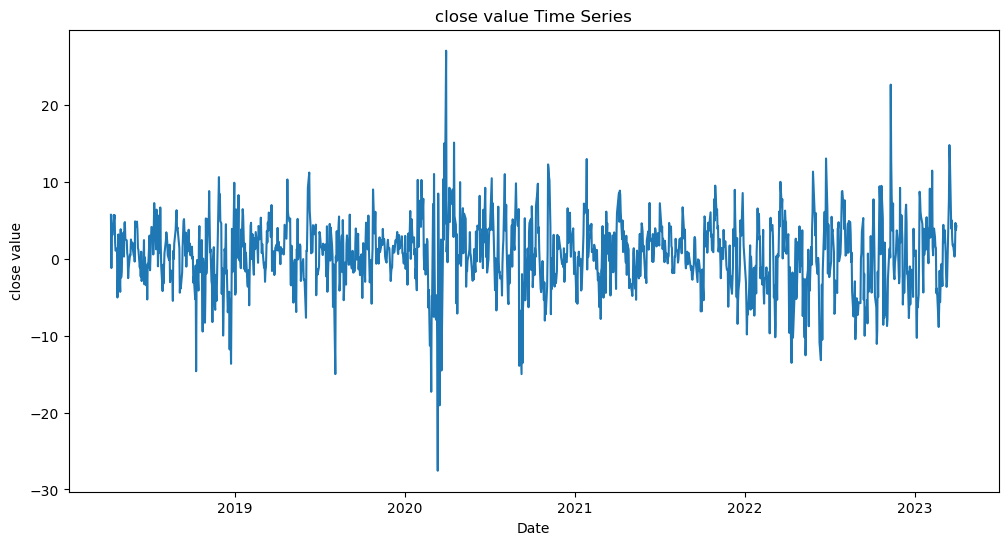

In [31]:
timeseries2 = df_daily_final['close_diff_15']
column = 'close value'
#close_diff_15
plt.figure(figsize=(12, 6))
plt.plot(timeseries2)
#plt.plot(timeseries2)
plt.title(f'{column} Time Series')
plt.xlabel('Date')
plt.ylabel(column)
plt.show()

In [32]:
# data_check = data[(data.index.get_level_values('t') > '2022-04-01') & (data.index.get_level_values('t') < '2022-05-01')]
# data_check['c']

# timeseries = data_check['c']
# column = 'close value'

# plt.figure(figsize=(12, 6))
# plt.plot(timeseries)
# plt.title(f'{column} Time Series')
# plt.xlabel('Date')
# plt.ylabel(column)
# plt.show()

Estandarizar datos

In [33]:
#Escalaré los datos para no dar mas a algunas variables (rangos muy distintos). No se escsala target

# Get the index of the 'close' column
# close_index = df_daily_final.columns.get_loc('c2')

# # Scale all columns except the 'close' column
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_scaled_except_close = scaler.fit_transform(df_daily_final.drop('c2', axis=1))

# # Add the 'close' column back to the dataset
# df_scaled = df_scaled_except_close.copy()
# df_scaled = np.insert(df_scaled, close_index, df_daily_final['c2'].values.astype('float64'), axis=1)
# df_scaled[0]


In [135]:
# #Escalaré los datos para no dar mas peso a algunas variables (rangos muy distintos)
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(data)
# df_scaled_df = pd.DataFrame(df_scaled, columns=data.columns)

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_daily_final)
df_scaled_df = pd.DataFrame(df_scaled, columns=df_daily_final.columns, index=df_daily_final.index)
df_scaled_df

,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/E_diff,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff
t,,,,,,,,,,,,,,,,,,,,,
2018-04-10,0.229767,0.145416,0.577730,0.653721,0.684527,0.617053,0.499887,0.657522,0.294854,0.346255,...,0.690951,0.590965,0.523365,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-11,0.210910,0.128822,0.465061,0.526947,0.627206,0.598231,0.485129,0.509901,0.259805,0.321829,...,0.657044,0.568957,0.469931,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-12,0.244954,0.133353,0.557734,0.650331,0.680238,0.637158,0.473090,0.633802,0.309415,0.307731,...,0.689117,0.589774,0.520474,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-13,0.212752,0.129477,0.481566,0.549077,0.656621,0.638421,0.460554,0.525874,0.351992,0.306522,...,0.669880,0.577289,0.490159,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-16,0.185257,0.111101,0.555414,0.631285,0.682256,0.662159,0.445595,0.632154,0.315067,0.293261,...,0.682470,0.585460,0.510000,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,0.229583,0.245349,0.433427,0.508779,0.646239,0.772083,0.451040,0.435681,0.506087,0.611413,...,0.665430,0.574534,0.483392,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2023-03-28,0.187111,0.209882,0.484309,0.508110,0.549349,0.700652,0.439161,0.520930,0.411846,0.592221,...,0.626826,0.501641,0.334824,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2023-03-29,0.214314,0.227704,0.565288,0.673756,0.665590,0.755606,0.425483,0.637293,0.429971,0.571543,...,0.712940,0.664245,0.666235,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475


Creación de dataset para entrenamiento, validación y test

In [35]:
df_daily_final.shape

(1347, 65)

In [36]:
#Separo los datos en train, validacion y test (aqui primero la cantidad)
num_train_samples = int(0.7 * len(df_daily_final))
num_val_samples =  len(df_daily_final) -num_train_samples #int(0.3 * len(df_daily_final))
num_test_samples = len(df_daily_final) - num_train_samples - num_val_samples
print("Número de train_samples:", num_train_samples)
print("Número de val_samples:", num_val_samples)
print("Número de test_samples:", num_test_samples)

Número de train_samples: 942
Número de val_samples: 405
Número de test_samples: 0


In [37]:
timestamp_at_num_train_samples = df_daily_final.index[num_train_samples]
timestamp_at_num_train_samples

Timestamp('2021-10-13 00:00:00')

In [38]:
#Inicio lo necesario para crear las secuencias para el modelo. Iré con secuencias de 7 dias tomando todas las variables y el target será solo el close.
days_to_predict = 1
target_column_index = df_daily_final.columns.get_loc('close_diff_15') # Columna target
sampling_rate = 1 #Dado que los datos ya estan resumidos por día, se va tomando fila a fila sin saltos
sequence_length = 5 # 4 (4 días anteriores a tomar en cuenta).
delay = sampling_rate * (sequence_length ) #Comienzo del target
batch_size = 10 #La cantidad de batch que creará, cada una con X (samples) e y (target c)

# Create a new array without the 'c2' column
#df_scaled_no_target = np.delete(df_scaled, target_column_index, axis=1)

In [39]:
df_scaled[:-delay ].shape[0]

1342

In [40]:
df_scaled.shape

(1347, 65)

In [41]:
t = df_scaled[0:0+days_to_predict, 1]
t

array([0.14541565])

In [42]:
targets = np.array([df_scaled[i:i+days_to_predict, target_column_index] for i in range(len(df_scaled) - delay)])
targets

array([[0.60927506],
       [0.48256522],
       [0.58672616],
       ...,
       [0.5520764 ],
       [0.53647409],
       [0.53829544]])

In [43]:
# Create targets with a 7-day window
targets = np.array([df_scaled[i:i+days_to_predict, target_column_index] for i in range(len(df_scaled) - delay)]) #nultiple output
#targets = np.array([df_scaled[i+sequence_length:i+delay+1, target_column_index] for i in range(len(df_scaled) - delay)]) #1 output

# Create datasets for the model
train_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled[:-delay ],
    targets=  df_scaled[:, target_column_index][delay:] ,       #targets[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled[:-delay ],
    targets=  df_scaled[:, target_column_index][delay:]  ,      #targets[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=df_scaled[:-delay ].shape[0]-1)

# test_dataset = keras.utils.timeseries_dataset_from_array(
#     df_scaled[:-delay ],
#     targets=targets[delay:],
#     sampling_rate=sampling_rate,
#     sequence_length=sequence_length,
#     shuffle=True,
#     batch_size=batch_size,
#     start_index=num_train_samples + num_val_samples)

In [44]:
for x_batch, y_batch in train_dataset:
    print("x_batch shape:", x_batch.shape)
    print("x_batch values:\n", x_batch)
    print("y_batch shape:", y_batch.shape)
    print("y_batch values:\n", y_batch)
    break

x_batch shape: (10, 5, 65)
x_batch values:
 tf.Tensor(
[[[1.23105466e-01 1.26522376e-01 5.37126245e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [1.55310442e-01 1.39546479e-01 5.40070497e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [1.91586288e-01 1.85800126e-01 5.13216241e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [1.69630556e-01 1.90839751e-01 4.69905979e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [1.83950575e-01 1.82660904e-01 4.64630796e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]]

 [[4.40310442e-01 3.33989734e-01 4.93835144e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [3.56763789e-01 2.45968300e-01 5.15760104e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [4.46909995e-01 3.16182718e-01 6.57982582e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [3.49819515e-01 2.49834384e-01 4.40833627e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [4.32195326e-01 2.96060893e-01 7

In [45]:
#Crea los dataset para modelo (PARA UNA SOLA PREDICCION)
# train_dataset = keras.utils.timeseries_dataset_from_array(
#     df_scaled[:-delay],
#     targets=df_scaled[:, target_column_index][delay:],
#     sampling_rate=sampling_rate,
#     sequence_length=sequence_length,
#     shuffle=True,
#     batch_size=batch_size,
#     start_index=0,
#     end_index=num_train_samples)

# val_dataset = keras.utils.timeseries_dataset_from_array(
#     df_scaled[:-delay],
#     targets=df_scaled[:, target_column_index][delay:],
#     sampling_rate=sampling_rate,
#     sequence_length=sequence_length,
#     shuffle=True,
#     batch_size=batch_size,
#     start_index=num_train_samples,
#     end_index=num_train_samples + num_val_samples)

# test_dataset = keras.utils.timeseries_dataset_from_array(
#     df_scaled[:-delay],
#     targets=df_scaled[:, target_column_index][delay:],
#     sampling_rate=sampling_rate,
#     sequence_length=sequence_length,
#     shuffle=True,
#     batch_size=batch_size,
#     start_index=num_train_samples + num_val_samples)

In [46]:
#Revisa shape para posterior modelo.
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (10, 5, 65)
targets shape: (10,)


Ejemplo de los datos que estaremos pasando al modelo (por cada ejemplo, 54 valores de todas las columnas de 7 dias completos y como target el valor del dia siguiente)

In [47]:
df_daily_final[0:15]

,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/E_diff,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff
t,,,,,,,,,,,,,,,,,,,,,
2018-04-10,1.676972e+06,12396.187500,1.001315,1.000917,1.000354,1.000072,-5.330285,0.252657,11.745643,12.160338,...,1.082824,3.039329,1.028682,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2018-04-11,1.539376e+06,10982.187500,0.999551,0.999681,1.000150,1.000044,-5.362118,-0.104301,11.610421,12.109805,...,-0.349698,-0.981552,-0.332213,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2018-04-12,1.787785e+06,11368.266667,1.001002,1.000884,1.000339,1.000101,-5.388087,0.195300,11.801823,12.080636,...,1.005317,2.821781,0.955052,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2018-04-13,1.552815e+06,11038.000000,0.999809,0.999897,1.000255,1.000103,-5.415128,-0.065680,11.966088,12.078135,...,0.192609,0.540627,0.182979,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2018-04-16,1.352190e+06,9472.133333,1.000966,1.000698,1.000346,1.000137,-5.447396,0.191315,11.823627,12.050701,...,0.724501,2.033570,0.688276,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2018-04-17,1.671874e+06,11015.937500,1.001047,1.001142,1.000608,1.000225,-5.481057,0.195462,11.838920,12.028076,...,1.737554,4.877063,1.650676,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2018-04-18,1.313222e+06,9104.187500,1.000366,1.000352,1.000549,1.000247,-5.516177,0.029339,11.428985,11.980376,...,0.751162,2.108404,0.713604,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2018-04-19,1.468210e+06,10074.062500,0.999585,0.999770,1.000312,1.000212,-5.548208,-0.160140,11.776714,11.960576,...,-0.205971,-0.578130,-0.195672,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2018-04-20,1.939876e+06,10775.750000,0.999403,0.999361,0.999989,1.000135,-5.565944,-0.191367,11.437682,11.907210,...,-1.019324,-2.861095,-0.968358,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0


In [48]:
#Un ejemplo de unos datos para poder entender mejor lo creado
#Veo como input los valores de las 14 variables y como target la temperatura
print("Inputs para primer sample:", samples.numpy()[1]) 
print("Targets para primer sample :", targets[1])

Inputs para primer sample: [[2.00994680e-01 1.56498717e-01 4.42670296e-01 4.97824553e-01
  5.68527444e-01 5.84953320e-01 2.51743916e-01 4.32463781e-01
  2.97490797e-01 2.07677177e-01 4.24691269e-01 3.80632378e-01
  4.62800644e-01 1.21635074e-01 3.86751540e-01 4.56750875e-01
  2.91930511e-01 5.36920280e-01 5.50262043e-01 3.69884356e-01
  9.78151515e-01 9.36586318e-01 7.43533541e-01 8.54906029e-01
  6.78880891e-01 5.05949542e-01 1.27355813e-02 8.17685891e-01
  8.86562969e-01 2.19238197e-03 4.53065415e-01 6.65616632e-01
  6.30754620e-01 5.65807046e-01 2.43298659e-01 5.46641772e-01
  6.76382184e-01 4.65794045e-01 4.56636761e-01 4.40705563e-01
  4.50770548e-01 4.42292171e-01 4.51018010e-01 6.10084030e-01
  4.57039552e-01 5.71446201e-01 4.30459105e-01 4.60001572e-01
  5.55383868e-01 5.51452914e-01 4.17346668e-01 3.88906832e-01
  5.10479199e-01 5.41794591e-01 1.35819561e-01 6.51259699e-01
  5.60809515e-01 4.51018010e-01 4.39104744e-01 3.81284402e-01
  3.41968426e-01 4.85674599e-01 6.03201217e

# Modelo

Combina capa convolucional para extraer idealmente patrones iniciales de menor dimensionalidad en los datos y luego una LSTM para predicción final y teniendo en cuenta el orden temporal.

In [49]:
sequence_length

5

In [50]:
df_scaled.shape[-1]

65

In [51]:
# class CustomMetric(tf.keras.metrics.Metric):
#     def __init__(self, day, name='custom_metric', **kwargs):
#         super(CustomMetric, self).__init__(name=f"{name}_{day}", **kwargs)
#         self.day = day
#         self.mae = tf.keras.metrics.MeanAbsoluteError()

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         self.mae.update_state(y_true[:, self.day - 1], y_pred[:, self.day - 1], sample_weight)

#     def result(self):
#         return self.mae.result()

#     def reset_state(self):
#         self.mae.reset_state()

In [52]:
#Modelo

# Parámetros
epochs = 100
batch_size = 10
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# def mae_day1(y_true, y_pred):
#     return tf.keras.losses.mean_absolute_error(y_true[:, 0], y_pred[:, 0])

# def mae_day2(y_true, y_pred):
#     return tf.keras.losses.mean_absolute_error(y_true[:, 1], y_pred[:, 1])


# inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))
# x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
# x = layers.LSTM(32, recurrent_dropout=0.1, return_sequences=True)(inputs)
# x = layers.LSTM(32, recurrent_dropout=0.1)(x)
# x = layers.Dropout(0.1)(x)
# outputs = layers.Dense(2)(x)
# model = keras.Model(inputs, outputs)

#opcion inicial
# inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))
# x = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
# x = layers.LSTM(256, recurrent_dropout=0.1, return_sequences=True)(inputs)
# x = layers.Dropout(0.3)(x)
# x = layers.LSTM(64, recurrent_dropout=0.1)(x)
# x = layers.Dropout(0.1)(x)
# outputs = layers.Dense(2)(x)
# model = keras.Model(inputs, outputs)

#opcion v2
inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))
x = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
x = layers.LSTM(256, recurrent_dropout=0.1, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(64, recurrent_dropout=0.1)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)






# # Define the input layer
# inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))

# # Add a convolutional layer with L2 regularization
# x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(inputs)

# # Add a recurrent layer with L1 regularization and dropout
# x = layers.LSTM(64, kernel_regularizer=l1(0.01), recurrent_regularizer=l1(0.01), dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(x)

# # Add another recurrent layer with L1 regularization and dropout
# x = layers.LSTM(32, kernel_regularizer=l1(0.01), recurrent_regularizer=l1(0.01), dropout=0.2, recurrent_dropout=0.2)(x)

# # Add two dense layers with L2 regularization and dropout
# x1 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
# x1 = layers.Dropout(0.2)(x1)
# output1 = layers.Dense(1)(x1)

# x2 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
# x2 = layers.Dropout(0.2)(x2)
# output2 = layers.Dense(1)(x2)

# # Concatenate the outputs and define the model
# outputs = layers.Concatenate(axis=-1, name='concatenate')([output1, output2])
# model = keras.Model(inputs, outputs)





In [53]:
# Model compilation
# model.compile(optimizer=optimizer,
#               loss=tf.keras.losses.MeanAbsoluteError(),
#               metrics={'concatenate': [tf.keras.metrics.MeanAbsoluteError(name='mae_day1'),
#                                        tf.keras.metrics.MeanAbsoluteError(name='mae_day2')]})


#model.compile(optimizer=optimizer, loss=[mae_day1, mae_day2], metrics=[CustomMetric(day=1), CustomMetric(day=2)])



model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
#alternativa probada: optimizer="rmsprop"

In [54]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 65)]           0         
                                                                 
 conv1d (Conv1D)             (None, 3, 128)            25088     
                                                                 
 lstm (LSTM)                 (None, 3, 256)            394240    
                                                                 
 dropout (Dropout)           (None, 3, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 501,569
Trainable params: 501,569
Non-trainable

In [55]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    verbose=0)
                    #,callbacks=[early_stopping])

# history = model.fit(train_dataset,
#  epochs=epochs,
#  validation_data=val_dataset, verbose = 0)
# 1 min 43 seg

In [56]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [57]:
mae = history.history["mae"]
len(mae)

100

In [58]:
val_mae = history.history["val_mae"]
len(val_mae)

100

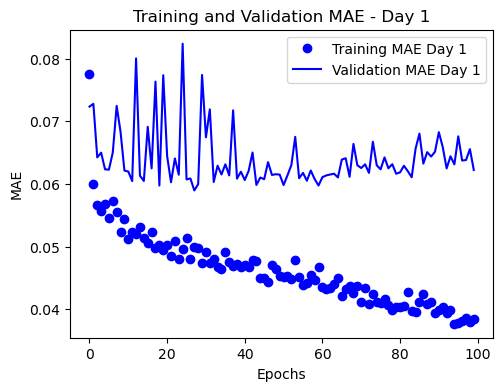

In [59]:
mae = history.history["mae"]
val_mae = history.history["val_mae"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot( mae, "bo", label="Training MAE Day 1")
plt.plot(val_mae, "b", label="Validation MAE Day 1")
plt.title("Training and Validation MAE - Day 1")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()



plt.show()


In [60]:
# train_mae = history.history["mae"][-1]
# val_mae = history.history["val_mae"][-1]

# print(f"MAE en el conjunto de entrenamiento: {train_mae:.4f}")
# print(f"MAE en el conjunto de validación: {val_mae:.4f}")

# Pruebas con las predicciones

Pequeña prueba de solo un ejemplo

In [61]:
sequence_length

5

In [62]:
df_scaled.shape[-1]

65

In [199]:
# Test Predict

# Selecciono una secuencia de ejemplo
inicio = 76
primer_ejemplo = df_scaled[inicio : sequence_length+inicio]

# Ajuste shape para que coincida con la entrada esperada por el modelo
primer_ejemplo_reshaped = np.reshape(primer_ejemplo, (1, sequence_length, df_scaled.shape[-1]))

# Hago la predicción usando el modelo
testprediccion = model.predict(primer_ejemplo_reshaped)

print(testprediccion)


1/1 [==============================] - 0s 32ms/step
[[0.52881867]]


Ahora algo que entregue todas las predicciones y las agregue como columna al dataset

In [127]:
df_scaled_df

,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/E_diff,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff
0,0.229767,0.145416,0.577730,0.653721,0.684527,0.617053,0.499887,0.657522,0.294854,0.346255,...,0.690951,0.590965,0.523365,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
1,0.210910,0.128822,0.465061,0.526947,0.627206,0.598231,0.485129,0.509901,0.259805,0.321829,...,0.657044,0.568957,0.469931,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2,0.244954,0.133353,0.557734,0.650331,0.680238,0.637158,0.473090,0.633802,0.309415,0.307731,...,0.689117,0.589774,0.520474,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
3,0.212752,0.129477,0.481566,0.549077,0.656621,0.638421,0.460554,0.525874,0.351992,0.306522,...,0.669880,0.577289,0.490159,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
4,0.185257,0.111101,0.555414,0.631285,0.682256,0.662159,0.445595,0.632154,0.315067,0.293261,...,0.682470,0.585460,0.510000,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,0.229583,0.245349,0.433427,0.508779,0.646239,0.772083,0.451040,0.435681,0.506087,0.611413,...,0.665430,0.574534,0.483392,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
1343,0.187111,0.209882,0.484309,0.508110,0.549349,0.700652,0.439161,0.520930,0.411846,0.592221,...,0.626826,0.501641,0.334824,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
1344,0.214314,0.227704,0.565288,0.673756,0.665590,0.755606,0.425483,0.637293,0.429971,0.571543,...,0.712940,0.664245,0.666235,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
1345,0.214308,0.246580,0.536878,0.634464,0.713805,0.789073,0.409379,0.589422,0.492441,0.566694,...,0.702237,0.644035,0.625045,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475


In [64]:
df_scaled.shape

(1347, 65)

In [65]:
primer_ejemplo.shape

(5, 65)

In [66]:
def predict_close(df_scaled, sequence_length, model):
    num_samples =  len(df_scaled) - sequence_length
    dataiteration_list = []
    for i in range(num_samples):
        dataiteration = df_scaled[i : i + sequence_length]
        dataiteration = np.reshape(dataiteration , (1, sequence_length, df_scaled.shape[-1]))
        #Append the dataiteration result to the list
        dataiteration_list.append(dataiteration)

    
    # Convert the list to a numpy array and concatenate along the first axis
    dataiterations_array = np.concatenate(dataiteration_list, axis=0)
    
    predictions = model.predict(dataiterations_array)
    
    return predictions

In [67]:
predictions = predict_close(df_scaled, sequence_length, model)

42/42 [==============================] - 0s 2ms/step


In [202]:
# Assuming 'predictions' is your NumPy array
positive_count = np.sum(predictions > 0)
negative_count = np.sum(predictions < 0)

print(f"Positive values count: {positive_count}")
print(f"Negative values count: {negative_count}")

Positive values count: 1341
Negative values count: 1


In [68]:
df_scaled.shape

(1347, 65)

In [72]:
len(predictions)

1342

In [73]:
# Convert 'df_scaled' to a pandas DataFrame
df_scaled_Predicciones = pd.DataFrame(df_scaled, columns=df_daily_final.columns, index=df_daily_final.index)


# Add the predictions as new columns in 'df_scaled_Predicciones'
df_scaled_Predicciones['predictions'] = np.nan

# Assign the predictions starting from the 'sequence_length' row
df_scaled_Predicciones.loc[df_scaled_Predicciones.index[sequence_length:], 'predictions'] = predictions

#df_scaled_Predicciones.iloc[sequence_length:, 'predictions'] = predictions
# df_scaled_Predicciones.iloc[sequence_length +1:, -1] = predictions[:-1, 1]
#df_scaled_Predicciones.iloc[sequence_length:, -1] = predictions[:, 1]
df_scaled_Predicciones[0:10]


,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff,predictions
t,,,,,,,,,,,,,,,,,,,,,
2018-04-10,0.229767,0.145416,0.577730,0.653721,0.684527,0.617053,0.499887,0.657522,0.294854,0.346255,...,0.590965,0.523365,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-11,0.210910,0.128822,0.465061,0.526947,0.627206,0.598231,0.485129,0.509901,0.259805,0.321829,...,0.568957,0.469931,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-12,0.244954,0.133353,0.557734,0.650331,0.680238,0.637158,0.473090,0.633802,0.309415,0.307731,...,0.589774,0.520474,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-13,0.212752,0.129477,0.481566,0.549077,0.656621,0.638421,0.460554,0.525874,0.351992,0.306522,...,0.577289,0.490159,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-16,0.185257,0.111101,0.555414,0.631285,0.682256,0.662159,0.445595,0.632154,0.315067,0.293261,...,0.585460,0.510000,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-17,0.229068,0.129218,0.560577,0.676741,0.755955,0.722742,0.429990,0.633869,0.319031,0.282325,...,0.601024,0.547787,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.534481
2018-04-18,0.179917,0.106783,0.517083,0.595804,0.739290,0.737540,0.413708,0.565169,0.212777,0.259269,...,0.585870,0.510994,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.552954
2018-04-19,0.201157,0.118165,0.467249,0.536054,0.672576,0.713749,0.398859,0.486809,0.302907,0.249699,...,0.571165,0.475292,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.575499
2018-04-20,0.265797,0.126399,0.455587,0.494151,0.581905,0.660603,0.390636,0.473895,0.215031,0.223904,...,0.558670,0.444953,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.577564


gráfico final

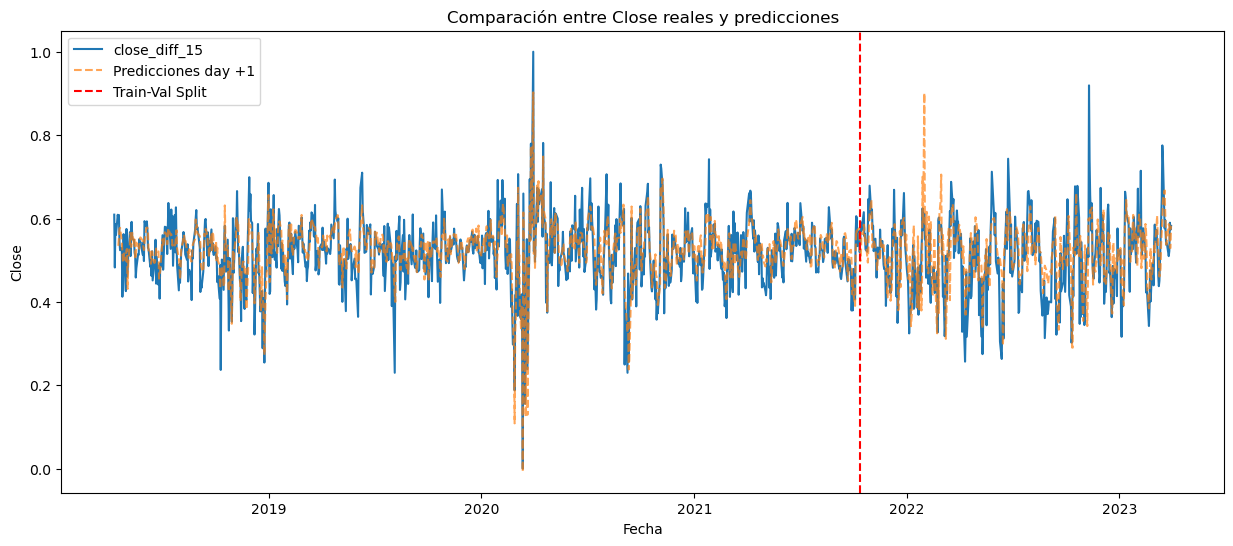

In [74]:
# Encuentro el índice de la columna "c" en el DataFrame original
C_index = df_daily.columns.get_loc('close_diff_15')

# Obtengo la información de escala (min y max) para la columna "C". 
# C_min = scaler.data_min_[C_index]
# C_range = scaler.data_range_[C_index]

# Convierte las predicciones a la escala original
# predictions_original = (df_scaled_Predicciones[['predictions_day_1']] * C_range) + C_min

# Creo un nuevo DataFrame con las columnas "c" y "predictions"
#df_comparison = df_scaled_Predicciones[['c']].copy()
#df_scaled_Predicciones['predictions_day_1'] = df_scaled_Predicciones[['predictions_day_1']] #predictions_original

# CreO un gráfico de línea comparando las temperaturas reales y las predicciones
plt.figure(figsize=(15, 6))
plt.plot(df_scaled_Predicciones.index, df_scaled_Predicciones['close_diff_15'], label='close_diff_15')
plt.plot(df_scaled_Predicciones.index,df_scaled_Predicciones['predictions'], label='Predicciones day +1', linestyle='--', alpha=0.7)
plt.axvline(x=timestamp_at_num_train_samples, color='r', label='Train-Val Split',linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.title('Comparación entre Close reales y predicciones')
plt.legend()
plt.show()

In [75]:
#  Find the index of the 'c' column
C_index = df_daily_final.columns.get_loc('close_diff_15')

# Find the minimum and range of the 'c' column in the original dataset
C_min = scaler.data_min_[C_index]
C_range = scaler.data_range_[C_index]
original_values = scaler.inverse_transform(df_scaled)
df_original = pd.DataFrame(original_values, columns=df_daily_final.columns, index=df_daily_final.index)

#Add the predictions as new columns in 'df_scaled_Predicciones'
df_original['predictions'] = np.nan

df_original.loc[df_original.index[sequence_length:], 'predictions'] = predictions
#df_original.iloc[sequence_length:, -2] = predictions[:, 0]

#df_scaled_Predicciones.iloc[sequence_length:, -1] = predictions[:, 1]


df_original['predictions'] = df_original['predictions'] * C_range + C_min


In [210]:
# Assuming 'df_original' is your DataFrame
positive_count = (df_original['predictions'] > 0).sum()
negative_count = (df_original['predictions'] < 0).sum()

print(f"Positive values count: {positive_count}")
print(f"Negative values count: {negative_count}")

Positive values count: 917
Negative values count: 425


In [209]:
# Assuming 'df_original' is your DataFrame
positive_count = (df_original['close_diff_15'] > 0).sum()
negative_count = (df_original['close_diff_15'] < 0).sum()

print(f"Positive values count: {positive_count}")
print(f"Negative values count: {negative_count}")


Positive values count: 793
Negative values count: 554


In [76]:
timestamp_at_num_train_samples

Timestamp('2021-10-13 00:00:00')

In [228]:
# Assuming 'df_original' is your DataFrame
negative_predictions = df_original[df_original['predictions'] < 0]

# Display the DataFrame with negative predictions
negative_predictions


,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff,predictions
t,,,,,,,,,,,,,,,,,,,,,
2018-04-25,2.247225e+06,14452.600000,1.000412,0.999319,0.999438,0.999941,-5.550286,0.113706,12.345222,12.027146,...,-5.645401,-1.910726,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,-0.577778
2018-04-30,2.553267e+06,14326.687500,0.998495,0.998947,0.999988,1.000078,-5.381467,-0.343709,11.929506,12.155077,...,-3.634159,-1.230007,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,-0.305985
2018-05-03,2.389703e+06,18309.923077,1.000633,1.000108,0.999837,0.999999,-5.431944,0.144281,12.716032,12.258040,...,-1.443273,-0.488486,0.0,0.0,-5.385247e-17,0.0,0.0,-1.121591e-16,0.0,-3.989787
2018-05-04,1.589006e+06,11843.500000,1.000761,1.000692,1.000103,1.000057,-5.443272,0.159774,11.960066,12.230667,...,2.736428,0.926163,0.0,0.0,5.385247e-17,0.0,0.0,1.121591e-16,0.0,-0.755384
2018-05-16,1.160864e+06,7249.866667,0.999931,0.999903,0.999982,1.000104,-5.686353,-0.050384,11.544107,11.876552,...,-0.526305,-0.178132,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,-0.089612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27,1.407243e+06,17719.533333,1.000365,1.000176,0.999677,0.999890,-5.517799,0.116995,12.028610,12.635728,...,5.254289,1.492831,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,-1.693751
2023-02-28,1.400221e+06,15506.062500,0.999698,0.999879,0.999742,0.999889,-5.549119,-0.049564,12.015590,12.577631,...,-1.770407,-0.503002,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,-0.342646
2023-03-01,1.722887e+06,20583.937500,0.999397,0.999424,0.999700,0.999867,-5.560178,-0.123091,12.672445,12.581548,...,-4.777663,-1.357414,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,-0.044615


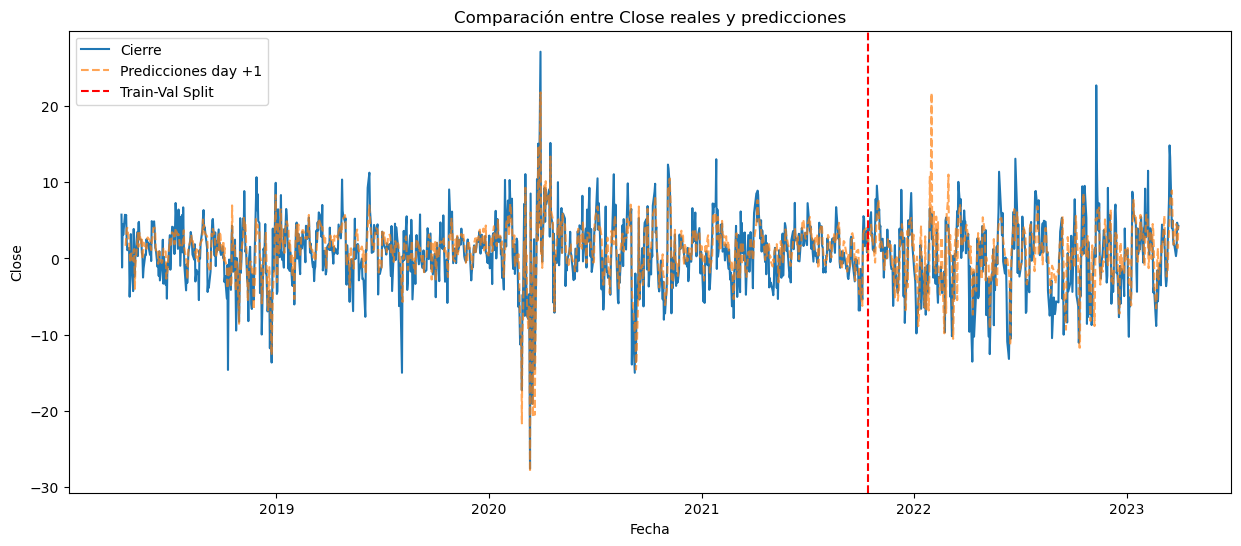

In [77]:
plt.figure(figsize=(15, 6))
plt.plot(df_original.index, df_original['close_diff_15'], label='Cierre')
plt.plot(df_original.index,df_original['predictions'], label='Predicciones day +1', linestyle='--', alpha=0.7)
plt.axvline(x=timestamp_at_num_train_samples, color='r', label='Train-Val Split',linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.title('Comparación entre Close reales y predicciones')
plt.legend()
plt.show()

In [78]:
# Remove any rows with missing values in df_original
df_mae_final = df_original.dropna()

# Calculate the mean absolute error between 'c' and 'predictions_output1'



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


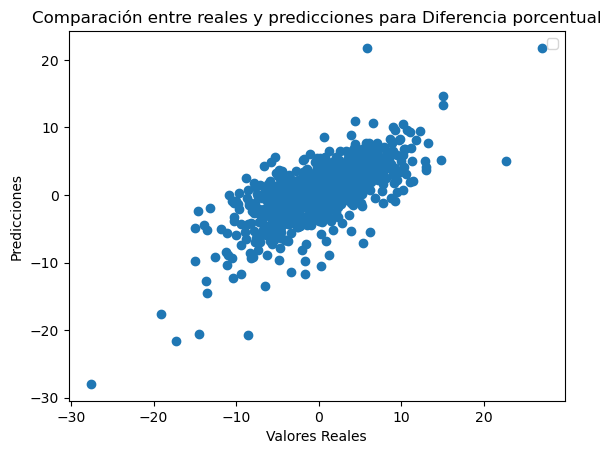

<Figure size 640x480 with 0 Axes>

R-squared value: 0.4894507881451853
Mean absolute error: 2.3952643525785575
Mean Squared Error: 10.763520232013157
Root Mean Squared Error: 3.2807804303264727


In [79]:

# Remove rows with NA values in the 'predictions_output1' and 'predictions_output2' columns
# df_mae_final_filtered = df_mae_final.dropna(subset=['predictions_output1', 'predictions_output2'])

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plt.scatter(df_mae_final['close_diff_15'],df_mae_final['predictions'])
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre reales y predicciones para Diferencia porcentual')
plt.legend()
plt.show()
# Scatter plot for Actual Close vs. Predicted Close day +1

plt.tight_layout()
plt.show()

r2 = r2_score(df_mae_final['close_diff_15'], df_mae_final['predictions'])
print("R-squared value:", r2)

mae = mean_absolute_error(df_mae_final['close_diff_15'], df_mae_final['predictions'])
print(f"Mean absolute error: {mae}")

mse = mean_squared_error(df_mae_final['close_diff_15'], df_mae_final['predictions'])
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


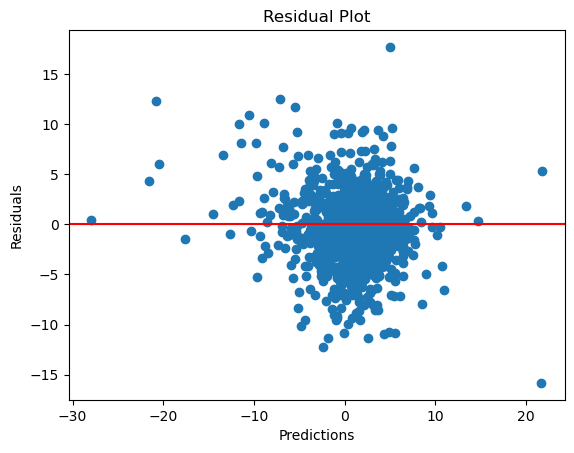

In [80]:
residuals = df_mae_final['close_diff_15'] - df_mae_final['predictions']

plt.scatter(df_mae_final['predictions'], residuals)
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.show()


Directional accuracy:

In [81]:
# Compute the sign of the actual and predicted changes
actual_signs = np.sign(df_mae_final['close_diff_15'])
predicted_signs = np.sign(df_mae_final['predictions'])

# Calculate directional accuracy
directional_accuracy = (actual_signs == predicted_signs).mean()
print("Directional Accuracy:", directional_accuracy)


Directional Accuracy: 0.7660208643815202


Predicciones marco temporal mas pequeño

In [245]:
df_original.columns

Index(['v', 'n', 'diff', 'emaS', 'emaM', 'emaL', 'std', 'pc', 'mvS', 'mvL',
       'rsi', 'rsid', 'rlmD', 'obvsL', 'obvSH', 'lavs', 'avgv', 'macd',
       'signal', 'macds', 'financial_data_age', 'EPS_Growth', 'Gross_Margin',
       'time_embed_day_sin', 'time_embed_day_cos', 'time_embed_week_sin',
       'time_embed_week_cos', 'time_embed_month_sin', 'time_embed_month_cos',
       'time_embed_year_sin', 'time_embed_year_cos', 'market_correlation',
       'market_long_term_trend', 'market_short_term_trend', 'market_change',
       'alpha', 'beta', 'close_diff_15', 'o_diff', 'h_diff', 'l_diff',
       'c_diff', 'vw_diff', 'mnS_diff', 'mnL_diff', 'rlmS_diff', 'rlmL_diff',
       'obv_diff', 'obvmS_diff', 'obvmL_diff', 'lavgv_diff', 'lavm_diff',
       'ewm_12_diff', 'ewm_26_diff', 'macd_std_diff', 'P/E_diff', 'P/S_diff',
       'P/B_diff', 'ROE_diff', 'ROA_diff', 'Operating_Margin_diff',
       'Net_Profit_Margin_diff', 'Current_Ratio_diff', 'Debt_to_Equity_diff',
       'FCF_diff', 'pre

In [246]:
Base00 = df_original[(df_original.index.get_level_values('t') >= '2018-04-18') & (df_original.index.get_level_values('t') <= '2018-04-25')]
Base00[['c_diff', 'close_diff_15', 'predictions']]

,c_diff,close_diff_15,predictions
t,,,
2018-04-18,0.63,5.696579,2.659283
2018-04-19,-0.61,2.150461,3.891459
2018-04-20,-0.98,1.073414,4.004298
2018-04-23,0.39,1.361569,2.240189
2018-04-24,-2.12,-5.020461,0.827524
2018-04-25,0.53,-2.317876,-0.577778


In [237]:
Base0 = df_scaled_Predicciones[(df_scaled_Predicciones.index.get_level_values('t') >= '2018-04-18') & (df_scaled_Predicciones.index.get_level_values('t') <= '2018-04-25')]
Base0

,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff,predictions
t,,,,,,,,,,,,,,,,,,,,,
2018-04-18,0.179917,0.106783,0.517083,0.595804,0.739290,0.737540,0.413708,0.565169,0.212777,0.259269,...,0.585870,0.510994,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.552954
2018-04-19,0.201157,0.118165,0.467249,0.536054,0.672576,0.713749,0.398859,0.486809,0.302907,0.249699,...,0.571165,0.475292,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.575499
2018-04-20,0.265797,0.126399,0.455587,0.494151,0.581905,0.660603,0.390636,0.473895,0.215031,0.223904,...,0.558670,0.444953,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.577564
2018-04-23,0.234472,0.124955,0.513999,0.581119,0.597736,0.661401,0.382325,0.573051,0.534888,0.256540,...,0.577417,0.490472,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.545286
2018-04-24,0.337711,0.189944,0.387993,0.439675,0.518944,0.609244,0.387616,0.367128,0.471818,0.271481,...,0.557371,0.441800,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.519438
2018-04-25,0.307918,0.169548,0.520043,0.489816,0.426837,0.527240,0.397895,0.600059,0.450263,0.281876,...,0.543430,0.407952,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.493725


In [238]:
periodotestsinprediccion = Base0.iloc[:-1]
periodotestsinprediccion =  periodotestsinprediccion.drop(columns= ['predictions'])
periodotestsinprediccion

,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/E_diff,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff
t,,,,,,,,,,,,,,,,,,,,,
2018-04-18,0.179917,0.106783,0.517083,0.595804,0.739290,0.737540,0.413708,0.565169,0.212777,0.259269,...,0.683101,0.585870,0.510994,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-19,0.201157,0.118165,0.467249,0.536054,0.672576,0.713749,0.398859,0.486809,0.302907,0.249699,...,0.660446,0.571165,0.475292,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-20,0.265797,0.126399,0.455587,0.494151,0.581905,0.660603,0.390636,0.473895,0.215031,0.223904,...,0.641194,0.558670,0.444953,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-23,0.234472,0.124955,0.513999,0.581119,0.597736,0.661401,0.382325,0.573051,0.534888,0.256540,...,0.670079,0.577417,0.490472,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-24,0.337711,0.189944,0.387993,0.439675,0.518944,0.609244,0.387616,0.367128,0.471818,0.271481,...,0.639194,0.557371,0.441800,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475


In [239]:
periodotestarray = periodotestsinprediccion.values
periodotestarray.shape

(5, 65)

In [240]:

periodotestreshaped = np.reshape(periodotestarray, (1, sequence_length, df_scaled.shape[-1]))
periodotestreshaped.shape


(1, 5, 65)

In [241]:
testprediccionfinal = model.predict(periodotestreshaped)
print(testprediccion)

1/1 [==============================] - 0s 16ms/step
[[0.52881867]]


In [242]:
testprediccionfinalescalareal = testprediccionfinal * C_range + C_min
testprediccionfinalescalareal

array([[-0.57777977]], dtype=float32)